In [44]:
# Import Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

In [45]:
# Data Transformations
train_transforms = transforms.Compose([transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       #transforms.RandomAffine(degrees=(-7.0, 7.0), translate=(0.1,0.1), scale=(0.9, 1.1), fill=(1,)),
                                       #transforms.ColorJitter(brightness=0.1, contrast=0.1),
                                       #transforms.RandomAdjustSharpness(1.1),
                                       #transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])
test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))
                                      ])

In [46]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [47]:
SEED = 99

cuda = torch.cuda.is_available()

torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

#data loader arguments - something you will fetch these from cmdt prompt
train_dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

test_dataloader_args = dict(shuffle=False, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=False, batch_size=64)

train_dataloader = torch.utils.data.DataLoader(train, **train_dataloader_args)
test_dataloader = torch.utils.data.DataLoader(test, **test_dataloader_args)

In [48]:
torch.cuda.is_available()

True

In [49]:
# # Statistics
# train_data = train.train_data
# train_data = train.transform(train_data.numpy())

# print('Train Data Stats:')
# print('- Numpy Shape ', train.train_data.cpu().numpy().shape)
# print('- Tensor shape ', train.train_data.size())
# print('- Min ', torch.min(train_data))
# print('- Max ', torch.max(train_data))
# print('- mean ', torch.mean(train_data))
# print('- Std ', torch.std(train_data))
# print('- var ', torch.var(train_data))

torch.Size([64, 1, 28, 28])
torch.Size([64])


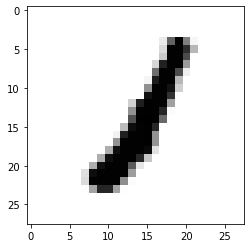

In [50]:
# Print some images
diter = iter(train_dataloader)
images, labels = diter.next()

print(images.shape)
print(labels.shape)

%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

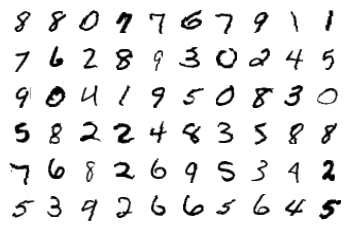

In [51]:
figure = plt.figure()
num_images = 60
for index in range(1, num_images+1):
  plt.subplot(6, 10, index)
  plt.axis('off')
  plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Model

In [52]:
dropout_value = 0.01
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        # self.convblock5 = nn.Sequential(
        #     nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
        #     nn.ReLU(),            
        #     nn.BatchNorm2d(16),
        #     nn.Dropout(dropout_value)
        # ) # output_size = 8

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # output_size = 8

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=14, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 

        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        #x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [53]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 12, 10, 10]             864
             ReLU-12           [-1, 12, 10, 10]               0
      BatchNorm2d-13           [-1, 12, 10, 10]              24
          Dropout-14           [-1

In [54]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [55]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=8, gamma=0.01)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_dataloader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_dataloader)

EPOCH: 0


Loss=0.37541574239730835 Batch_id=937 Accuracy=94.44: 100%|██████████| 938/938 [00:11<00:00, 79.09it/s]



Test set: Average loss: 0.0444, Accuracy: 9859/10000 (98.59%)

EPOCH: 1


Loss=0.07676538825035095 Batch_id=937 Accuracy=98.02: 100%|██████████| 938/938 [00:11<00:00, 79.20it/s]



Test set: Average loss: 0.0364, Accuracy: 9885/10000 (98.85%)

EPOCH: 2


Loss=0.017059624195098877 Batch_id=937 Accuracy=98.35: 100%|██████████| 938/938 [00:11<00:00, 78.21it/s]



Test set: Average loss: 0.0327, Accuracy: 9883/10000 (98.83%)

EPOCH: 3


Loss=0.17036381363868713 Batch_id=937 Accuracy=98.58: 100%|██████████| 938/938 [00:11<00:00, 78.38it/s]



Test set: Average loss: 0.0304, Accuracy: 9914/10000 (99.14%)

EPOCH: 4


Loss=0.004475714638829231 Batch_id=937 Accuracy=98.66: 100%|██████████| 938/938 [00:11<00:00, 79.49it/s]



Test set: Average loss: 0.0272, Accuracy: 9909/10000 (99.09%)

EPOCH: 5


Loss=0.004099765792489052 Batch_id=937 Accuracy=98.77: 100%|██████████| 938/938 [00:11<00:00, 79.04it/s]



Test set: Average loss: 0.0286, Accuracy: 9906/10000 (99.06%)

EPOCH: 6


Loss=0.008736259303987026 Batch_id=937 Accuracy=98.80: 100%|██████████| 938/938 [00:11<00:00, 79.25it/s]



Test set: Average loss: 0.0262, Accuracy: 9909/10000 (99.09%)

EPOCH: 7


Loss=0.01247859001159668 Batch_id=937 Accuracy=98.85: 100%|██████████| 938/938 [00:11<00:00, 79.84it/s]



Test set: Average loss: 0.0220, Accuracy: 9921/10000 (99.21%)

EPOCH: 8


Loss=0.0666138157248497 Batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [00:11<00:00, 80.01it/s]



Test set: Average loss: 0.0197, Accuracy: 9936/10000 (99.36%)

EPOCH: 9


Loss=0.046316105872392654 Batch_id=937 Accuracy=99.21: 100%|██████████| 938/938 [00:11<00:00, 80.41it/s]



Test set: Average loss: 0.0190, Accuracy: 9940/10000 (99.40%)

EPOCH: 10


Loss=0.015911150723695755 Batch_id=937 Accuracy=99.22: 100%|██████████| 938/938 [00:12<00:00, 78.07it/s]



Test set: Average loss: 0.0189, Accuracy: 9938/10000 (99.38%)

EPOCH: 11


Loss=0.007962384261190891 Batch_id=937 Accuracy=99.29: 100%|██████████| 938/938 [00:11<00:00, 80.11it/s]



Test set: Average loss: 0.0184, Accuracy: 9939/10000 (99.39%)

EPOCH: 12


Loss=0.0019018036546185613 Batch_id=937 Accuracy=99.30: 100%|██████████| 938/938 [00:11<00:00, 78.64it/s]



Test set: Average loss: 0.0182, Accuracy: 9938/10000 (99.38%)

EPOCH: 13


Loss=0.02076808735728264 Batch_id=937 Accuracy=99.29: 100%|██████████| 938/938 [00:11<00:00, 79.11it/s]



Test set: Average loss: 0.0184, Accuracy: 9944/10000 (99.44%)

EPOCH: 14


Loss=0.0008669004309922457 Batch_id=937 Accuracy=99.28: 100%|██████████| 938/938 [00:12<00:00, 77.75it/s]



Test set: Average loss: 0.0185, Accuracy: 9941/10000 (99.41%)



Text(0.5, 1.0, 'Test Accuracy')

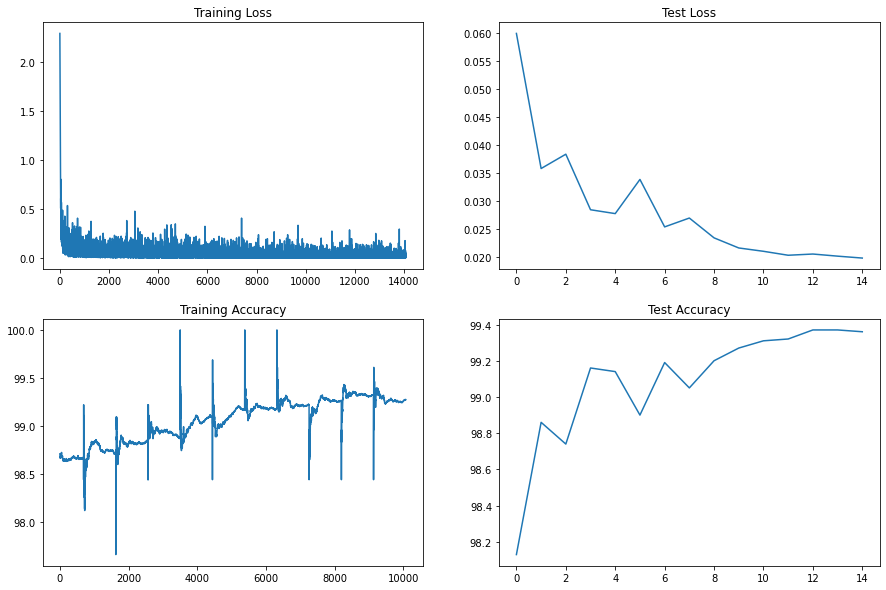

In [13]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")